In [2]:
#Save con Nodos
import os
from keras.models import load_model
import itertools
from matplotlib import pyplot as plt
from keras.utils import to_categorical
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
import os, sys
dirpath = os.getcwd().split("code")[0]+"code/"
sys.path.append(dirpath)
from sklearn.utils import class_weight
import numpy as np

from evaluation import calculate_metrics
from sklearn.metrics import confusion_matrix,accuracy_score
import pandas as pd
from keras.regularizers import l2
from keras.activations import tanh
from keras.models import Sequential
from keras.layers import *
from keras.losses import categorical_crossentropy,binary_crossentropy
from keras.optimizers import SGD
from keras.callbacks import LearningRateScheduler
from keras import optimizers
from keras import backend as K
from time import time
import random
from random import shuffle,seed
from sklearn.metrics import classification_report
import math
from keras.regularizers import l2
from keras.callbacks import LearningRateScheduler
from keras.callbacks import EarlyStopping
from keras.backend import eval



In [3]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score,f1_score, confusion_matrix
from sklearn.preprocessing import normalize
import time

def plot_confusion_matrix(cm, target_names, title='Confusion matrix (f1-score)',cmap=None, normalize=True):
    
    import itertools
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

In [4]:
fold = "../../KOI_Data/"
df_sets = pd.read_csv(fold+"/koi_sets_unb.csv") 
mask_train = (df_sets["Set"] == "Train").values
mask_test = (df_sets["Set"] == "Test").values
mask_unlabeled = (df_sets["Set"] == "Unlabeled").values
df_sets.head()

KOI Name        Set
0  K00889.01       Test
1  K01009.01      Train
2  K07621.01      Train
3  K06252.01      Train
4  K00958.01  Unlabeled

In [5]:
df_meta = pd.read_csv(fold+"/koi_metadata.csv")
df_meta_train = df_meta[mask_train]
df_meta_test = df_meta[mask_test]
df_meta_unb = df_meta[mask_unlabeled]

df_meta_train.head()

KOI Name NExScI Disposition Kepler Name      Period  \
1  K01009.01     FALSE POSITIVE         NaN    5.092465   
2  K07621.01     FALSE POSITIVE         NaN  275.073650   
3  K06252.01     FALSE POSITIVE         NaN    8.460439   
6  K04162.01     FALSE POSITIVE         NaN    0.539366   
9  K00998.01     FALSE POSITIVE         NaN  161.788327   

   Time of Transit Epoch  First Transit Time (BJD)  Impact Parameter  \
1              357.53594               2455190.536             0.161   
2              315.24860               2455148.249             0.595   
3              133.77449               2454966.774             1.061   
6              131.97457               2454964.975             0.988   
9              214.03900               2455047.039             0.267   

   Duration  Transit Depth    r/R       ...          Teff  log(g)  \
1   3.65900          254.0  0.014       ...        5037.0   4.547   
2   3.37000          228.9  0.014       ...        5604.0   4.226   
3   4.73492        76412.9  0.478       ...        5951.0   4.638   
6   5.43400          145.0  0.016       ...        6341.0   3.301   
9   5.31000        87750.0  0.273       ...        6018.0   4.327   

   Metallicity  Stellar Radius  Stellar Mass  Max single event sigma  \
1        -0.20           0.751         0.727                   3.648   
2        -0.12           1.187         0.864                   5.909   
3        -1.06           0.702         0.796                 452.526   
6        -0.10           5.302         2.050                   4.847   
9         0.18           1.212         1.142                 341.666   

   Max Multievent sigma  Transit Model SNR  KOI count  Transit Number  
1                15.175               17.1          1             225  
2                 8.012                7.5          1               4  
3              3704.503             1797.4          1             164  
6                 9.076               57.6          1            1239  
9               806.993              704.5          1               9  

[5 rows x 31 columns]

In [6]:
y_train= (df_meta_train['NExScI Disposition'].values=="CONFIRMED")*1
y_val = (df_meta_test['NExScI Disposition'].values=="CONFIRMED")*1

### data augm

In [98]:
x_all = np.load("/work/work_teamEXOPLANET/MTF_margarita/no_invertidos/MTF_u10_d20.npy")
x_all2 = np.load("/work/work_teamEXOPLANET/MTF_margarita/invertidos/MTF_u10_d20.npy")

x_train1 = x_all[mask_train]
x_val = x_all[mask_test]
#x_unb = x_all[mask_unlabeled]

x_train2 = x_all2[mask_train]


x_train = np.concatenate([x_train1,x_train2])
if x_train.shape[0] != y_train.shape[0]:
    y_train = np.tile(y_train, (2))

x_train=np.expand_dims(np.asarray(x_train), axis=-1)
x_val=np.expand_dims(np.asarray(x_val), axis=-1)
x_test=np.expand_dims(np.asarray(x_test), axis=-1)

print ("Objetos de entrenamiento:",x_train.shape, y_train.shape)
print ("Objetos de validación:",x_val.shape,y_val.shape)

Objetos de entrenamiento: (9384, 30, 30, 1) (9384,)
Objetos de validación: (1565, 30, 30, 1) (1565,)


## canales

In [28]:
!ls /work/work_teamEXOPLANET/MTF_margarita/no_invertidos

MTF_u10_d10.npy  MTF_u10_d30.npy  MTF_u15_d20.npy  MTF_u5_d15.npy
MTF_u10_d15.npy  MTF_u15_d10.npy  MTF_u15_d30.npy  MTF_u5_d20.npy
MTF_u10_d20.npy  MTF_u15_d15.npy  MTF_u5_d10.npy   MTF_u5_d30.npy


In [29]:
x_all1 = np.load("/work/work_teamEXOPLANET/MTF_margarita/no_invertidos/MTF_u15_d30.npy")
x_all2 = np.load("/work/work_teamEXOPLANET/MTF_margarita/invertidos/MTF_u15_d30.npy")

x_all = np.concatenate([x_all1[:,:,:,None],x_all2[:,:,:,None]], axis=-1)

x_train = x_all[mask_train]
x_val = x_all[mask_test]
#x_unb = x_all[mask_unlabeled]

print ("Objetos de entrenamiento:",x_train.shape, y_train.shape)
print ("Objetos de validación:",x_val.shape,y_val.shape)

Objetos de entrenamiento: (4692, 45, 45, 2) (4692,)
Objetos de validación: (1565, 45, 45, 2) (1565,)


In [40]:
class_weights = class_weight.compute_class_weight('balanced', np.unique(y_train), y_train)#{0: 3.,   1: 6.,   2: 5.,  3: 3.}
print (class_weights)

[0.86762575 1.18003941]


In [40]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=x_train.shape[1:], strides=(1, 1),activation="relu", padding="valid"))
#model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), strides=(1, 1),activation="relu", padding="valid"))
#model.add(BatchNormalization())
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), strides=(1, 1), activation="relu", padding="valid"))
#model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), strides=(1, 1), activation="relu", padding="valid"))
#model.add(BatchNormalization())
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), strides=(1, 1), activation="relu", padding="valid"))
#model.add(BatchNormalization())
model.add(Conv2D(128, (3, 3), strides=(1, 1), activation="relu", padding="valid"))
#model.add(BatchNormalization())
#model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.25))

#model.add(Flatten())
model.add(GlobalAveragePooling2D())

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(1, activation='sigmoid'))
model.summary()

model.compile(loss='binary_crossentropy',optimizer='Adam',metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_34 (Conv2D)           (None, 43, 43, 32)        608       
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 41, 41, 32)        9248      
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 20, 20, 32)        0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 20, 20, 32)        0         
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 18, 18, 64)        18496     
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 16, 16, 64)        36928     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 8, 8, 64)          0         
__________

In [17]:
model = Sequential()
model.add(Flatten(input_shape=x_train.shape[1:]))
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
#model.add(Dense(128, activation='relu'))
#model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
model.summary()

model.compile(loss='binary_crossentropy',optimizer='Adam',metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 1800)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               461056    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 257       
Total params: 462,337
Trainable params: 461,825
Non-trainable params: 512
_________________________________________________________________


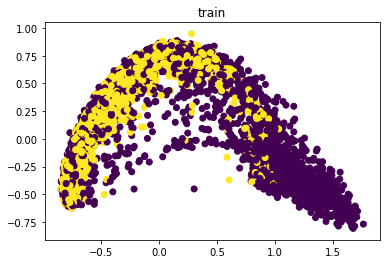

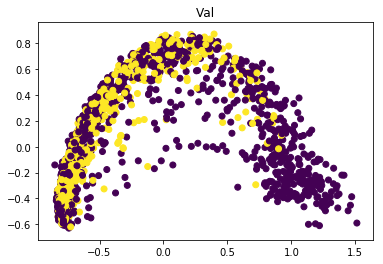

In [15]:
from sklearn.decomposition import PCA
dims_r = np.prod(x_train.shape[1:])

model = PCA(2)
plot_x = model.fit_transform(x_train.reshape([x_train.shape[0],dims_r]))
plt.scatter(plot_x[:,0],plot_x[:,1], c=y_train, cmap='viridis') #morado es falso positivo
plt.title("train")
plt.show()

plot_x = model.transform(x_val.reshape([x_val.shape[0],dims_r]))
plt.scatter(plot_x[:,0],plot_x[:,1], c=y_val, cmap='viridis') #morado es falso positivo
plt.title("Val")
plt.show()

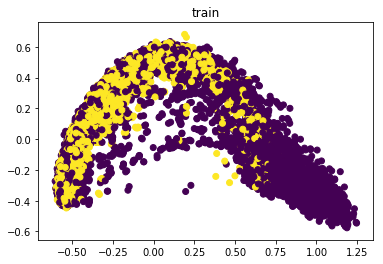

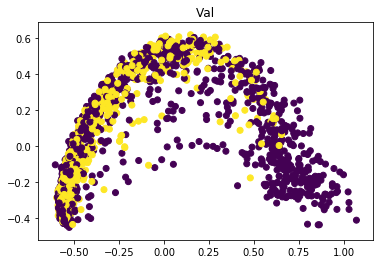

In [103]:
from sklearn.decomposition import PCA
dims_r = np.prod(x_train.shape[1:])
model = PCA(2)
plot_x = model.fit_transform(x_train.reshape([x_train.shape[0],dims_r]))
plt.scatter(plot_x[:,0],plot_x[:,1], c=y_train, cmap='viridis') #morado es falso positivo
plt.title("train")
plt.show()

plot_x = model.transform(x_val.reshape([x_val.shape[0],dims_r]))
plt.scatter(plot_x[:,0],plot_x[:,1], c=y_val, cmap='viridis') #morado es falso positivo
plt.title("Val")
plt.show()

In [41]:
hist=model.fit(x_train, y_train, batch_size=128, epochs=50, verbose=1, validation_data=(x_val,y_val))
plt.plot(hist.history['loss'],label="train_loss")
plt.plot(hist.history['val_loss'],label="val_loss")
plt.title("Model Loss BCE CNN") 
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(loc="upper right")
plt.show()

plt.plot(hist.history['acc'],label="Train accuracy" )
plt.plot(hist.history['val_acc'],label="Val accuracy" )
plt.title("Model Accuracy BCE CNN") 
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(loc="upper right")
plt.show()

Train on 4692 samples, validate on 1565 samples
Epoch 1/50
4692/4692 [==============================] - 11s 2ms/step - loss: 0.6042 - acc: 0.6168 - val_loss: 0.5965 - val_acc: 0.6773
Epoch 2/50
4692/4692 [==============================] - 9s 2ms/step - loss: 0.5670 - acc: 0.6215 - val_loss: 0.6007 - val_acc: 0.6773
Epoch 3/50
4692/4692 [==============================] - 9s 2ms/step - loss: 0.5571 - acc: 0.6315 - val_loss: 0.5921 - val_acc: 0.5706
Epoch 4/50
4692/4692 [==============================] - 9s 2ms/step - loss: 0.5572 - acc: 0.6394 - val_loss: 0.5983 - val_acc: 0.5412
Epoch 5/50
4692/4692 [==============================] - 9s 2ms/step - loss: 0.5589 - acc: 0.6343 - val_loss: 0.6117 - val_acc: 0.5240
Epoch 6/50
4692/4692 [==============================] - 9s 2ms/step - loss: 0.5502 - acc: 0.6398 - val_loss: 0.5956 - val_acc: 0.5572
Epoch 7/50
4692/4692 [==============================] - 9s 2ms/step - loss: 0.5519 - acc: 0.6468 - val_loss: 0.6031 - val_acc: 0.5291
Epoch 8/50
46

KeyboardInterrupt: 

F1 macro  F1 micro    F1 raw  F1 weighted  Precision raw  \
False Positive   0.66416   0.68115  0.739697     0.690948       0.827305   
Confirmed        0.66416   0.68115  0.588623     0.690948       0.504237   

                Recall raw  
False Positive    0.668868  
Confirmed         0.706931

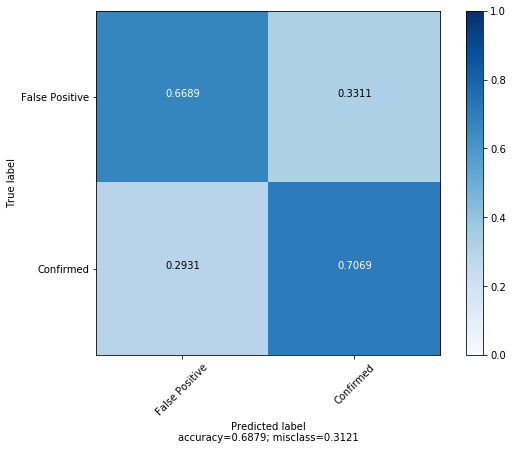

{'F1 weighted': 0.6909482625376592, 'Recall raw': array([0.66886792, 0.70693069]), 'F1 micro': 0.681150159744409, 'F1 raw': array([0.73969744, 0.58862325]), 'F1 macro': 0.6641603460339454, 'Confusion Matrix': array([[709, 351],
       [148, 357]]), 'Precision raw': array([0.82730455, 0.50423729])}


In [34]:
predichos=model.predict_classes(x_val)
print (calculate_metrics(y_val, predichos,'[VAL] Confusion Matrix 50 epochs CNN + reverse LC'))

In [47]:
def focal_loss(gamma=2., weights=1):   #weights np.asarray()
    weights= K.variable(weights)
    def focal_loss_fixed(y_true, y_pred):
        y_true = K.clip(y_true, K.epsilon(),1)
        y_pred = K.clip(y_pred,K.epsilon(),1)
        return - K.sum(weights* K.pow(1. - y_pred, gamma)* y_true * K.log(y_pred), axis=-1) 
    return focal_loss_fixed

In [48]:
model2 = Sequential()
model2.add(Conv2D(64, (3, 3), input_shape=(15,15,1), strides=(1, 1),activation="relu", padding="same"))
model2.add(MaxPooling2D((2,2)))
model2.add(Dropout(0.1))
model2.add(Conv2D(128, (3, 3), strides=(1, 1), activation="relu", padding="same"))
model2.add(Conv2D(256, (3, 3), strides=(1, 1), activation="relu", padding="same"))
#model1.add(Flatten())
model2.add(GlobalAveragePooling2D())
model2.add(Dense(256,activation='relu'))
model2.add(Dropout(0.2))
model2.add(Dense(128, activation='relu'))
model2.add(Dense(2, activation='softmax'))
model2.summary()

model2.compile(loss=focal_loss(2,weights=class_weights),optimizer='adam',metrics=['acc'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 15, 15, 64)        640       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 7, 7, 128)         73856     
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 7, 7, 256)         295168    
_________________________________________________________________
global_average_pooling2d_3 ( (None, 256)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 256)               65792     
__________

In [49]:
y_train_cat=to_categorical(y_train, 2)
y_train_cat[:3]
y_val_cat=to_categorical(y_val, 2)
y_val_cat[:3]

array([[0., 1.],
       [0., 1.],
       [1., 0.]], dtype=float32)

Train on 8383 samples, validate on 2797 samples
Epoch 1/50
8383/8383 [==============================] - 3s 380us/step - loss: 0.1458 - acc: 0.6523 - val_loss: 0.1557 - val_acc: 0.5388
Epoch 2/50
8383/8383 [==============================] - 2s 298us/step - loss: 0.1450 - acc: 0.6487 - val_loss: 0.1665 - val_acc: 0.5080
Epoch 3/50
8383/8383 [==============================] - 2s 292us/step - loss: 0.1429 - acc: 0.6526 - val_loss: 0.1576 - val_acc: 0.5463
Epoch 4/50
8383/8383 [==============================] - 2s 288us/step - loss: 0.1414 - acc: 0.6598 - val_loss: 0.1601 - val_acc: 0.5223
Epoch 5/50
8383/8383 [==============================] - 2s 287us/step - loss: 0.1410 - acc: 0.6595 - val_loss: 0.1550 - val_acc: 0.5509
Epoch 6/50
8383/8383 [==============================] - 2s 289us/step - loss: 0.1407 - acc: 0.6603 - val_loss: 0.1538 - val_acc: 0.5424
Epoch 7/50
8383/8383 [==============================] - 2s 291us/step - loss: 0.1397 - acc: 0.6650 - val_loss: 0.1601 - val_acc: 0.5184


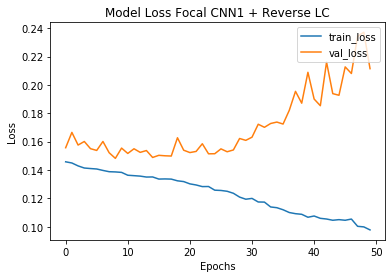

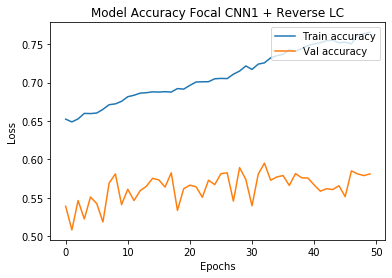

In [50]:
hist2=model2.fit(x_train, y_train_cat, batch_size=64, epochs=50, verbose=1, class_weight=class_weights, validation_data=(x_val,y_val_cat))
plt.plot(hist2.history['loss'],label="train_loss")
plt.plot(hist2.history['val_loss'],label="val_loss")
plt.title("Model Loss Focal CNN1 + Reverse LC") 
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(loc="upper right")
plt.show()

plt.plot(hist2.history['acc'],label="Train accuracy" )
plt.plot(hist2.history['val_acc'],label="Val accuracy" )
plt.title("Model Accuracy Focal CNN1 + Reverse LC") 
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(loc="upper right")
plt.show()

                Precision raw  Recall raw    F1 raw  F1 weighted  F1 macro  \
False Positive       0.849035    0.418579  0.560720     0.574706  0.580086   
Confirmed            0.457724    0.868317  0.599453     0.574706  0.580086   

                F1 micro  
False Positive   0.58098  
Confirmed        0.58098  


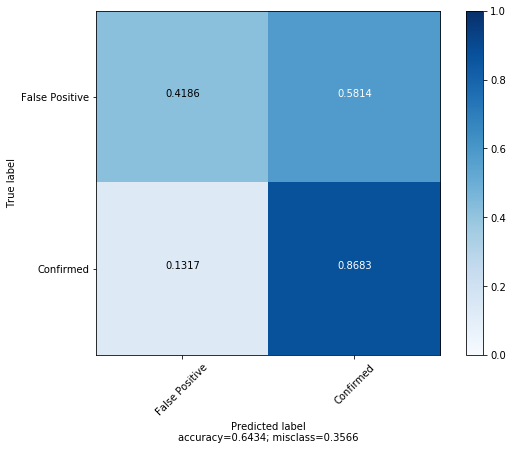

{'Precision raw': array([0.84903519, 0.45772443]), 'Recall raw': array([0.41857862, 0.86831683]), 'F1 raw': array([0.56071964, 0.59945318]), 'F1 weighted': 0.574706366530587, 'F1 macro': 0.5800864092902285, 'F1 micro': 0.5809796210225241, 'Confusion Matrix': array([[ 748, 1039],
       [ 133,  877]])}


In [51]:
predichos=model2.predict_classes(x_val)
print (calculate_metrics(y_val,predichos,'[VAL] Confusion Matrix 50 epochs CNN 1 Focal + Reverse LC'))

# Segundo Modelo

In [52]:
model3 = Sequential()
model3.add(Conv2D(32, (3, 3), input_shape=(15,15,1), strides=(1, 1),activation="relu", padding="same"))
model3.add(Dropout(0.25))
model3.add(Conv2D(32, (3, 3), input_shape=(15,15,1), strides=(1, 1),activation="relu", padding="same"))
model3.add(Dropout(0.15))
model3.add(GlobalAveragePooling2D())
model3.add(Dense(256, activation='relu'))
model3.add(Dropout(0.25))
model3.add(Dense(128,activation='relu'))
model3.add(Dense(1, activation='sigmoid'))
model3.summary()

model3.compile(loss='binary_crossentropy',optimizer='Adam',metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 15, 15, 32)        320       
_________________________________________________________________
dropout_7 (Dropout)          (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 15, 15, 32)        9248      
_________________________________________________________________
dropout_8 (Dropout)          (None, 15, 15, 32)        0         
_________________________________________________________________
global_average_pooling2d_4 ( (None, 32)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 256)               8448      
_________________________________________________________________
dropout_9 (Dropout)          (None, 256)               0         
__________

In [53]:
model4 = Sequential()
model4.add(Conv2D(32, (3, 3), input_shape=(15,15,1), strides=(1, 1),activation="relu", padding="same"))
model4.add(Dropout(0.2))
model4.add(Conv2D(32, (3, 3), input_shape=(15,15,1), strides=(1, 1),activation="relu", padding="same"))
model4.add(Dropout(0.1))
model4.add(GlobalAveragePooling2D())
model4.add(Dense(256, activation='relu'))
model4.add(Dropout(0.2))
model4.add(Dense(128, activation='relu'))
model4.add(Dense(2, activation='softmax'))
model4.summary()
model4.compile(loss=focal_loss(2,weights=class_weights),optimizer='adam',metrics=['acc'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 15, 15, 32)        320       
_________________________________________________________________
dropout_10 (Dropout)         (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 15, 15, 32)        9248      
_________________________________________________________________
dropout_11 (Dropout)         (None, 15, 15, 32)        0         
_________________________________________________________________
global_average_pooling2d_5 ( (None, 32)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 256)               8448      
_________________________________________________________________
dropout_12 (Dropout)         (None, 256)               0         
__________

Train on 8383 samples, validate on 2797 samples
Epoch 1/100
8383/8383 [==============================] - 2s 289us/step - loss: 0.5916 - acc: 0.6328 - val_loss: 0.6172 - val_acc: 0.5567
Epoch 2/100
8383/8383 [==============================] - 2s 206us/step - loss: 0.5566 - acc: 0.6609 - val_loss: 0.6278 - val_acc: 0.5463
Epoch 3/100
8383/8383 [==============================] - 2s 208us/step - loss: 0.5572 - acc: 0.6628 - val_loss: 0.6391 - val_acc: 0.5281
Epoch 4/100
8383/8383 [==============================] - 2s 208us/step - loss: 0.5562 - acc: 0.6592 - val_loss: 0.6097 - val_acc: 0.5492
Epoch 5/100
8383/8383 [==============================] - 2s 183us/step - loss: 0.5552 - acc: 0.6618 - val_loss: 0.6089 - val_acc: 0.5477
Epoch 6/100
8383/8383 [==============================] - 2s 182us/step - loss: 0.5543 - acc: 0.6622 - val_loss: 0.6103 - val_acc: 0.5599
Epoch 7/100
8383/8383 [==============================] - 2s 179us/step - loss: 0.5530 - acc: 0.6616 - val_loss: 0.6055 - val_acc: 

8383/8383 [==============================] - 1s 174us/step - loss: 0.5209 - acc: 0.6939 - val_loss: 0.5976 - val_acc: 0.6754
Epoch 61/100
8383/8383 [==============================] - 1s 175us/step - loss: 0.5165 - acc: 0.7043 - val_loss: 0.5857 - val_acc: 0.5888
Epoch 62/100
8383/8383 [==============================] - 1s 175us/step - loss: 0.5196 - acc: 0.6970 - val_loss: 0.6065 - val_acc: 0.5731
Epoch 63/100
8383/8383 [==============================] - 1s 176us/step - loss: 0.5165 - acc: 0.6992 - val_loss: 0.5778 - val_acc: 0.6925
Epoch 64/100
8383/8383 [==============================] - 1s 176us/step - loss: 0.5143 - acc: 0.7045 - val_loss: 0.5819 - val_acc: 0.6797
Epoch 65/100
8383/8383 [==============================] - 1s 176us/step - loss: 0.5165 - acc: 0.7024 - val_loss: 0.5961 - val_acc: 0.6689
Epoch 66/100
8383/8383 [==============================] - 1s 176us/step - loss: 0.5144 - acc: 0.6996 - val_loss: 0.6088 - val_acc: 0.6696
Epoch 67/100
8383/8383 [=======================

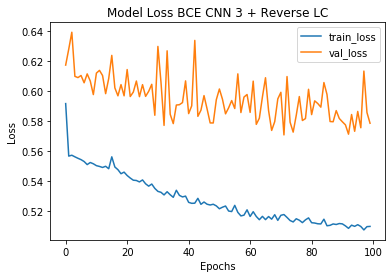

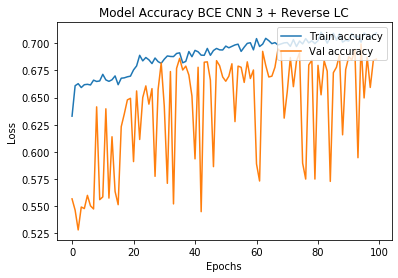

                Precision raw  Recall raw    F1 raw  F1 weighted  F1 macro  \
False Positive       0.767236    0.728595  0.747417     0.688023  0.665178   
Confirmed            0.559091    0.608911  0.582938     0.688023  0.665178   

                F1 micro  
False Positive  0.685377  
Confirmed       0.685377  


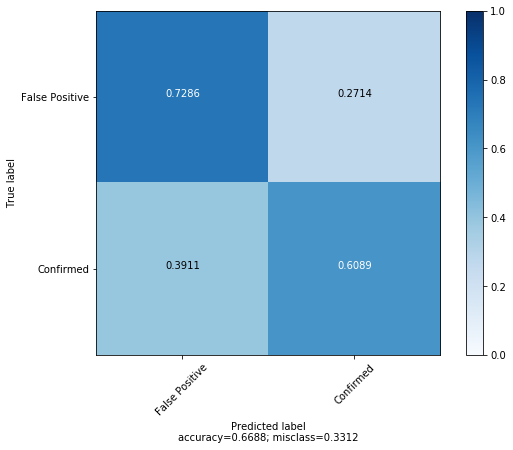

{'Precision raw': array([0.7672363 , 0.55909091]), 'Recall raw': array([0.72859541, 0.60891089]), 'F1 raw': array([0.74741676, 0.58293839]), 'F1 weighted': 0.6880234275356611, 'F1 macro': 0.6651775754838638, 'F1 micro': 0.6853771898462638, 'Confusion Matrix': array([[1302,  485],
       [ 395,  615]])}


In [54]:
hist3=model3.fit(x_train, y_train, batch_size=64, epochs=100, verbose=1, class_weight=class_weights, validation_data=(x_val,y_val))
plt.plot(hist3.history['loss'],label="train_loss")
plt.plot(hist3.history['val_loss'],label="val_loss")
plt.title("Model Loss BCE CNN 3 + Reverse LC") 
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(loc="upper right")
plt.show()

plt.plot(hist3.history['acc'],label="Train accuracy" )
plt.plot(hist3.history['val_acc'],label="Val accuracy" )
plt.title("Model Accuracy BCE CNN 3 + Reverse LC") 
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(loc="upper right")
plt.show()

predichos=model3.predict_classes(x_val)
print (calculate_metrics(y_val,predichos,'[VAL] Confusion Matrix 50 epochs CNN 3 BCE + Reverse LC'))

Train on 8383 samples, validate on 2797 samples
Epoch 1/100
8383/8383 [==============================] - 2s 284us/step - loss: 0.1482 - acc: 0.6480 - val_loss: 0.1574 - val_acc: 0.5341
Epoch 2/100
8383/8383 [==============================] - 2s 218us/step - loss: 0.1425 - acc: 0.6547 - val_loss: 0.1566 - val_acc: 0.5574
Epoch 3/100
8383/8383 [==============================] - 2s 199us/step - loss: 0.1423 - acc: 0.6557 - val_loss: 0.1572 - val_acc: 0.5227
Epoch 4/100
8383/8383 [==============================] - 2s 181us/step - loss: 0.1417 - acc: 0.6526 - val_loss: 0.1543 - val_acc: 0.5467
Epoch 5/100
8383/8383 [==============================] - 1s 179us/step - loss: 0.1414 - acc: 0.6568 - val_loss: 0.1537 - val_acc: 0.5420
Epoch 6/100
8383/8383 [==============================] - 2s 180us/step - loss: 0.1414 - acc: 0.6567 - val_loss: 0.1581 - val_acc: 0.5341
Epoch 7/100
8383/8383 [==============================] - 2s 180us/step - loss: 0.1409 - acc: 0.6621 - val_loss: 0.1572 - val_acc: 

8383/8383 [==============================] - 2s 209us/step - loss: 0.1320 - acc: 0.6958 - val_loss: 0.1495 - val_acc: 0.5863
Epoch 61/100
8383/8383 [==============================] - 2s 210us/step - loss: 0.1327 - acc: 0.6928 - val_loss: 0.1482 - val_acc: 0.5863
Epoch 62/100
8383/8383 [==============================] - 2s 206us/step - loss: 0.1323 - acc: 0.6938 - val_loss: 0.1496 - val_acc: 0.5849
Epoch 63/100
8383/8383 [==============================] - 2s 208us/step - loss: 0.1316 - acc: 0.6956 - val_loss: 0.1571 - val_acc: 0.5474
Epoch 64/100
8383/8383 [==============================] - 2s 207us/step - loss: 0.1314 - acc: 0.6931 - val_loss: 0.1504 - val_acc: 0.5724
Epoch 65/100
8383/8383 [==============================] - 2s 207us/step - loss: 0.1314 - acc: 0.6956 - val_loss: 0.1514 - val_acc: 0.5799
Epoch 66/100
8383/8383 [==============================] - 2s 210us/step - loss: 0.1316 - acc: 0.6932 - val_loss: 0.1513 - val_acc: 0.5656
Epoch 67/100
8383/8383 [=======================

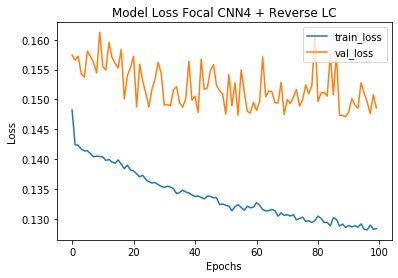

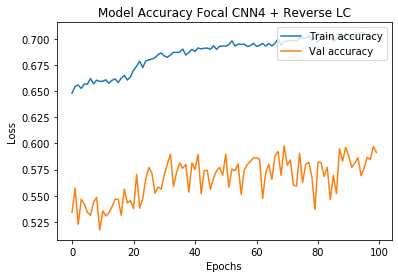

                Precision raw  Recall raw    F1 raw  F1 weighted  F1 macro  \
False Positive       0.869266    0.424175  0.570139     0.584736  0.590351   
Confirmed            0.465455    0.887129  0.610562     0.584736  0.590351   

                F1 micro  
False Positive  0.591348  
Confirmed       0.591348  


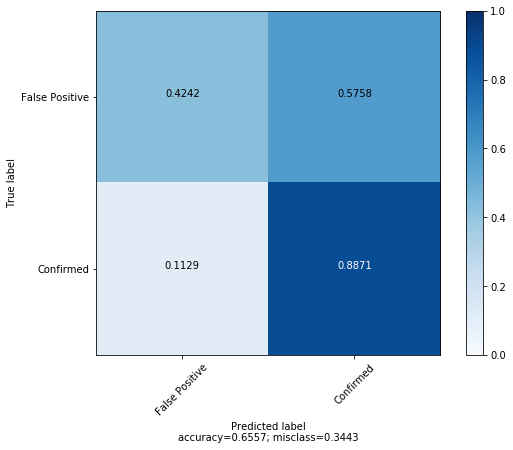

{'Precision raw': array([0.86926606, 0.46545455]), 'Recall raw': array([0.42417459, 0.88712871]), 'F1 raw': array([0.57013915, 0.61056218]), 'F1 weighted': 0.5847359540707248, 'F1 macro': 0.5903506653178143, 'F1 micro': 0.5913478727207723, 'Confusion Matrix': array([[ 758, 1029],
       [ 114,  896]])}


In [55]:
hist4=model4.fit(x_train, y_train_cat, batch_size=64, epochs=100, verbose=1, class_weight=class_weights, validation_data=(x_val,y_val_cat))
plt.plot(hist4.history['loss'],label="train_loss")
plt.plot(hist4.history['val_loss'],label="val_loss")
plt.title("Model Loss Focal CNN4 + Reverse LC") 
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(loc="upper right")
plt.show()

plt.plot(hist4.history['acc'],label="Train accuracy" )
plt.plot(hist4.history['val_acc'],label="Val accuracy" )
plt.title("Model Accuracy Focal CNN4 + Reverse LC") 
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(loc="upper right")
plt.show()

predichos=model4.predict_classes(x_val)
print (calculate_metrics(y_val,predichos,'[VAL] Confusion Matrix 50 epochs CNN 1 Focal + Reverse LC'))

Train on 8383 samples, validate on 2797 samples
Epoch 1/50
8383/8383 [==============================] - 1s 126us/step - loss: 0.5063 - acc: 0.7063 - val_loss: 0.5849 - val_acc: 0.6757
Epoch 2/50
8383/8383 [==============================] - 1s 116us/step - loss: 0.5024 - acc: 0.7137 - val_loss: 0.5810 - val_acc: 0.6857
Epoch 3/50
8383/8383 [==============================] - 1s 118us/step - loss: 0.5038 - acc: 0.7114 - val_loss: 0.5781 - val_acc: 0.6897
Epoch 4/50
8383/8383 [==============================] - 1s 115us/step - loss: 0.5061 - acc: 0.7113 - val_loss: 0.5775 - val_acc: 0.6915
Epoch 5/50
8383/8383 [==============================] - 1s 116us/step - loss: 0.5039 - acc: 0.7128 - val_loss: 0.5779 - val_acc: 0.6918
Epoch 6/50
8383/8383 [==============================] - 1s 117us/step - loss: 0.5048 - acc: 0.7104 - val_loss: 0.5882 - val_acc: 0.6793
Epoch 7/50
8383/8383 [==============================] - 1s 114us/step - loss: 0.5039 - acc: 0.7133 - val_loss: 0.5772 - val_acc: 0.6890


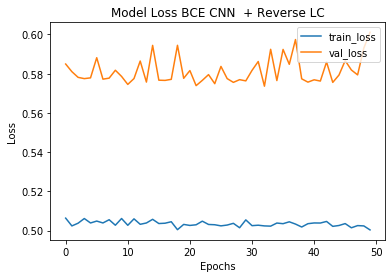

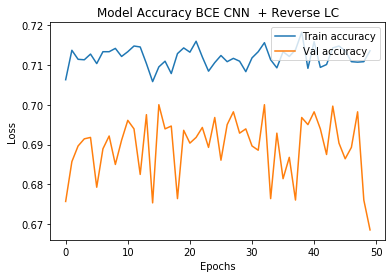

                Precision raw  Recall raw    F1 raw  F1 weighted  F1 macro  \
False Positive       0.778859    0.672076  0.721538     0.674303  0.656133   
Confirmed            0.533068    0.662376  0.590728     0.674303  0.656133   

                F1 micro  
False Positive  0.668573  
Confirmed       0.668573  


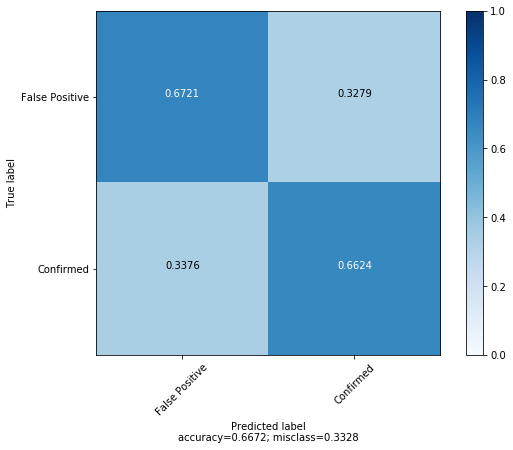

{'Precision raw': array([0.77885863, 0.53306773]), 'Recall raw': array([0.67207611, 0.66237624]), 'F1 raw': array([0.721538  , 0.59072848]), 'F1 weighted': 0.6743025264625702, 'F1 macro': 0.6561332381102056, 'F1 micro': 0.6685734715766893, 'Confusion Matrix': array([[1201,  586],
       [ 341,  669]])}


In [59]:
#mini-batches ?
hist3=model3.fit(x_train, y_train, batch_size=256 , epochs=50, verbose=1, class_weight=class_weights, validation_data=(x_val,y_val))
plt.plot(hist3.history['loss'],label="train_loss")
plt.plot(hist3.history['val_loss'],label="val_loss")
plt.title("Model Loss BCE CNN  + Reverse LC") 
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(loc="upper right")
plt.show()

plt.plot(hist3.history['acc'],label="Train accuracy" )
plt.plot(hist3.history['val_acc'],label="Val accuracy" )
plt.title("Model Accuracy BCE CNN  + Reverse LC") 
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(loc="upper right")
plt.show()

predichos=model3.predict_classes(x_val)
print (calculate_metrics(y_val,predichos,'[VAL] Confusion Matrix 50 epochs CNN BCE + Reverse LC'))

                Precision raw  Recall raw    F1 raw  F1 weighted  F1 macro  \
False Positive       0.755663    0.745808  0.750703     0.714859  0.708406   
Confirmed            0.660304    0.672016  0.666109     0.714859  0.708406   

                F1 micro  
False Positive  0.714541  
Confirmed       0.714541  


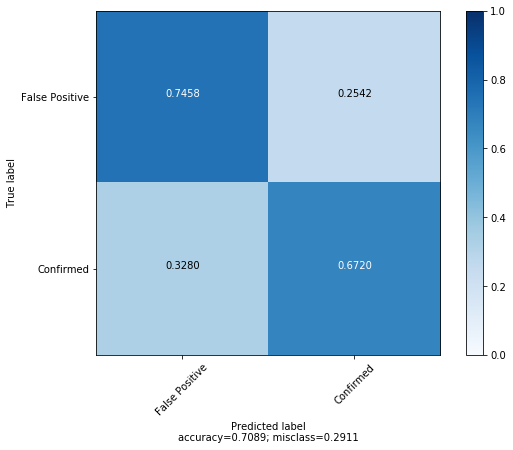

{'Precision raw': array([0.75566275, 0.66030429]), 'Recall raw': array([0.74580832, 0.67201577]), 'F1 raw': array([0.7507032 , 0.66610855]), 'F1 weighted': 0.7148592068856634, 'F1 macro': 0.7084058756701858, 'F1 micro': 0.7145413336514375, 'Confusion Matrix': array([[3603, 1228],
       [1165, 2387]])}


In [61]:
predichos=model3.predict_classes(x_train)
print (calculate_metrics(y_train,predichos,'[TRAIN] Confusion Matrix 50 epochs CNN BCE + Reverse LC'))

## modificar completamente los modelos!

In [62]:
model5 = Sequential()
model5.add(Conv2D(16, (3, 3), input_shape=(15,15,1), strides=(1, 1),activation="relu", padding="same"))
model5.add(BatchNormalization())
model5.add(Conv2D(16, (3, 3), input_shape=(15,15,1), strides=(1, 1),activation="relu", padding="same"))
model5.add(BatchNormalization())
model5.add(MaxPooling2D((2,2)))
model5.add(Conv2D(32, (3, 3), input_shape=(15,15,1), strides=(1, 1),activation="relu", padding="same"))
model5.add(BatchNormalization())
model5.add(Conv2D(32, (3, 3), input_shape=(15,15,1), strides=(1, 1),activation="relu", padding="same"))
model5.add(BatchNormalization())
model5.add(GlobalAveragePooling2D())
model5.add(Dropout(0.25))
model5.add(Dense(128, activation='relu'))
model5.add(Dropout(0.25))
model5.add(Dense(2, activation='softmax'))
model5.summary()
model5.compile(loss=focal_loss(2,weights=class_weights),optimizer='adam',metrics=['acc'])

W0719 03:48:41.826738 140316414314304 deprecation_wrapper.py:119] From /users/mbugueno/.local/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:1834: The name tf.nn.fused_batch_norm is deprecated. Please use tf.compat.v1.nn.fused_batch_norm instead.



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_14 (Conv2D)           (None, 15, 15, 16)        160       
_________________________________________________________________
batch_normalization_1 (Batch (None, 15, 15, 16)        64        
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 15, 15, 16)        2320      
_________________________________________________________________
batch_normalization_2 (Batch (None, 15, 15, 16)        64        
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 7, 7, 16)          0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 7, 7, 32)          4640      
_________________________________________________________________
batch_normalization_3 (Batch (None, 7, 7, 32)          128       
__________

Train on 8383 samples, validate on 2797 samples
Epoch 1/50
8383/8383 [==============================] - 2s 207us/step - loss: 0.1468 - acc: 0.6400 - val_loss: 0.5826 - val_acc: 0.6257
Epoch 2/50
8383/8383 [==============================] - 2s 198us/step - loss: 0.1408 - acc: 0.6653 - val_loss: 0.4107 - val_acc: 0.5638
Epoch 3/50
8383/8383 [==============================] - 2s 197us/step - loss: 0.1372 - acc: 0.6786 - val_loss: 0.1736 - val_acc: 0.6282
Epoch 4/50
8383/8383 [==============================] - 2s 197us/step - loss: 0.1355 - acc: 0.6827 - val_loss: 0.1637 - val_acc: 0.5692
Epoch 5/50
8383/8383 [==============================] - 2s 196us/step - loss: 0.1344 - acc: 0.6883 - val_loss: 0.1523 - val_acc: 0.5856
Epoch 6/50
8383/8383 [==============================] - 2s 196us/step - loss: 0.1315 - acc: 0.6965 - val_loss: 0.1561 - val_acc: 0.5810
Epoch 7/50
8383/8383 [==============================] - 2s 200us/step - loss: 0.1296 - acc: 0.6972 - val_loss: 0.1600 - val_acc: 0.5345


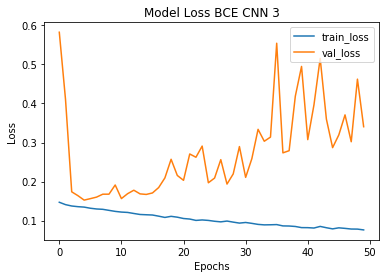

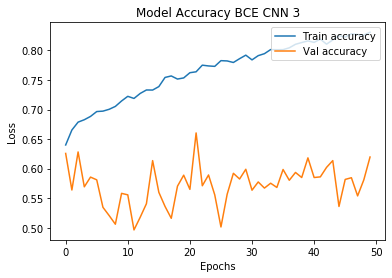

                Precision raw  Recall raw    F1 raw  F1 weighted  F1 macro  \
False Positive       0.727216    0.647454  0.685021     0.625379  0.602438   
Confirmed            0.477612    0.570297  0.519856     0.625379  0.602438   

                F1 micro  
False Positive  0.619592  
Confirmed       0.619592  


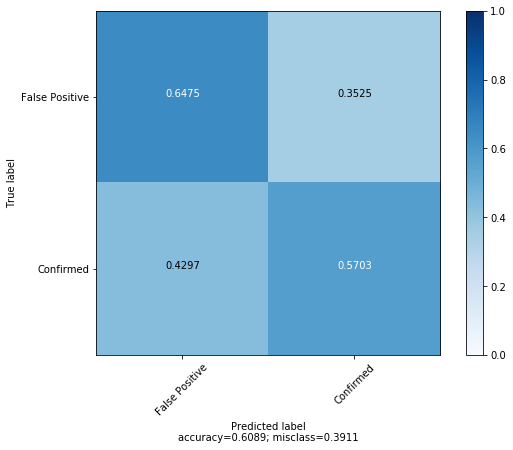

{'Precision raw': array([0.72721559, 0.47761194]), 'Recall raw': array([0.64745383, 0.57029703]), 'F1 raw': array([0.68502072, 0.5198556 ]), 'F1 weighted': 0.6253794002188048, 'F1 macro': 0.602438158994385, 'F1 micro': 0.6195924204504827, 'Confusion Matrix': array([[1157,  630],
       [ 434,  576]])}


In [66]:
hist5=model5.fit(x_train, y_train_cat, batch_size=256, epochs=50, verbose=1, class_weight=class_weights, validation_data=(x_val,y_val_cat))
plt.plot(hist5.history['loss'],label="train_loss")
plt.plot(hist5.history['val_loss'],label="val_loss")
plt.title("Model Loss BCE CNN 3") 
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(loc="upper right")
plt.show()
plt.plot(hist5.history['acc'],label="Train accuracy" )
plt.plot(hist5.history['val_acc'],label="Val accuracy" )
plt.title("Model Accuracy BCE CNN 3") 
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(loc="upper right")
plt.show()
predichos=model5.predict_classes(x_val)
print (calculate_metrics(y_val,predichos,'[VAL] Confusion Matrix 100 epochs CNN 5 BCE'))

In [43]:
model6 = Sequential()
model6.add(Conv2D(16, (3, 3), input_shape=(15,15,1), strides=(1, 1),activation="relu", padding="same"))
model6.add(BatchNormalization())
model6.add(Conv2D(16, (3, 3), input_shape=(15,15,1), strides=(1, 1),activation="relu", padding="same"))
model6.add(BatchNormalization())
model6.add(MaxPooling2D((2,2)))

model6.add(Conv2D(32, (3, 3), input_shape=(15,15,1), strides=(1, 1),activation="relu", padding="same"))
model6.add(BatchNormalization())
model6.add(Conv2D(32, (3, 3), input_shape=(15,15,1), strides=(1, 1),activation="relu", padding="same"))
model6.add(BatchNormalization())

model6.add(GlobalAveragePooling2D())
model6.add(Dense(128, activation='relu'))
model6.add(BatchNormalization())
model6.add(Dropout(0.2))
model6.add(Dense(2, activation='softmax'))
model6.summary()
model6.compile(loss=focal_loss(2,weights=class_weights),optimizer='adam',metrics=['acc'])


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_41 (Conv2D)           (None, 15, 15, 16)        160       
_________________________________________________________________
batch_normalization_6 (Batch (None, 15, 15, 16)        64        
_________________________________________________________________
conv2d_42 (Conv2D)           (None, 15, 15, 16)        2320      
_________________________________________________________________
batch_normalization_7 (Batch (None, 15, 15, 16)        64        
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 7, 7, 16)          0         
_________________________________________________________________
conv2d_43 (Conv2D)           (None, 7, 7, 32)          4640      
_________________________________________________________________
batch_normalization_8 (Batch (None, 7, 7, 32)          128       
__________

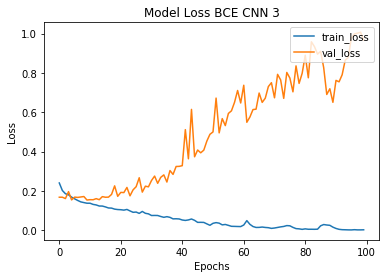

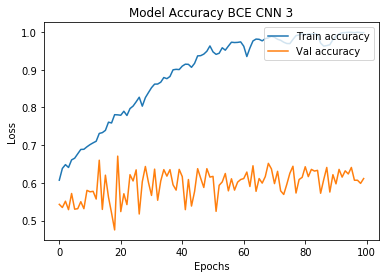

                F1 macro  F1 micro    F1 raw  F1 weighted  Precision raw  \
False Positive  0.585637  0.611502  0.689162      0.62235       0.752232   
Confirmed       0.585637  0.611502  0.482112      0.62235       0.423019   

                Recall raw  
False Positive    0.635849  
Confirmed         0.560396  


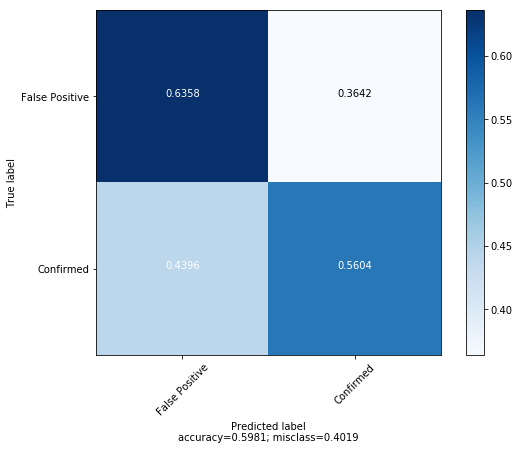

{'F1 macro': 0.5856369951540362, 'Recall raw': array([0.63584906, 0.56039604]), 'Confusion Matrix': array([[674, 386],
       [222, 283]]), 'Precision raw': array([0.75223214, 0.42301943]), 'F1 weighted': 0.6223501774327563, 'F1 micro': 0.6115015974440895, 'F1 raw': array([0.68916155, 0.48211244])}


In [44]:
hist6=model6.fit(x_train, y_train_cat, batch_size=128, epochs=100, verbose=0, class_weight=class_weights, validation_data=(x_val,y_val_cat))
plt.plot(hist6.history['loss'],label="train_loss")
plt.plot(hist6.history['val_loss'],label="val_loss")
plt.title("Model Loss Focal CNN 6") 
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(loc="upper right")
plt.show()

plt.plot(hist6.history['acc'],label="Train accuracy" )
plt.plot(hist6.history['val_acc'],label="Val accuracy" )
plt.title("Model Accuracy Focal CNN 6") 
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(loc="upper right")
plt.show()

predichos=model6.predict_classes(x_val)
print (calculate_metrics(y_val,predichos,'[VAL] Confusion Matrix 100 epochs CNN 6 Focal'))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_40 (Conv2D)           (None, 15, 15, 16)        160       
_________________________________________________________________
conv2d_41 (Conv2D)           (None, 15, 15, 16)        2320      
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 7, 7, 16)          0         
_________________________________________________________________
dropout_18 (Dropout)         (None, 7, 7, 16)          0         
_________________________________________________________________
conv2d_42 (Conv2D)           (None, 7, 7, 32)          4640      
_________________________________________________________________
conv2d_43 (Conv2D)           (None, 7, 7, 32)          9248      
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 3, 3, 32)          0         
__________

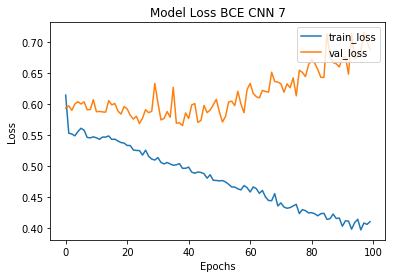

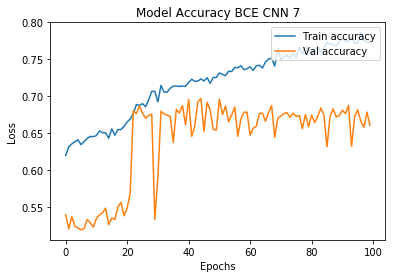

                F1 macro  F1 micro    F1 raw  F1 weighted  Precision raw  \
False Positive  0.630743  0.660064  0.734796     0.667643       0.779070   
Confirmed       0.630743  0.660064  0.526690     0.667643       0.478191   

                Recall raw  
False Positive    0.695283  
Confirmed         0.586139  


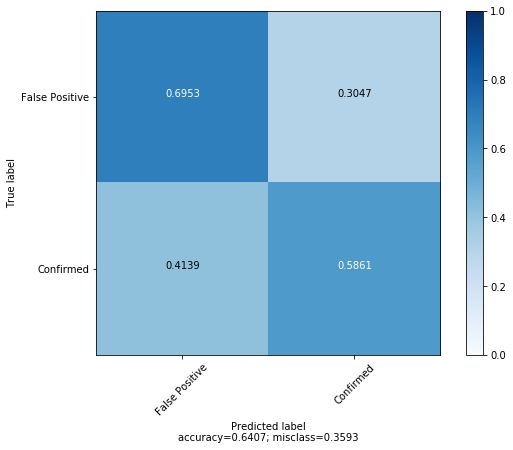

{'F1 macro': 0.6307430023097966, 'Recall raw': array([0.69528302, 0.58613861]), 'Confusion Matrix': array([[737, 323],
       [209, 296]]), 'Precision raw': array([0.77906977, 0.47819063]), 'F1 weighted': 0.6676434489693178, 'F1 micro': 0.6600638977635783, 'F1 raw': array([0.73479561, 0.52669039])}


In [25]:
model7 = Sequential()
model7.add(Conv2D(16, (3, 3), input_shape=(15,15,1), strides=(1, 1),activation="relu", padding="same"))
model7.add(Conv2D(16, (3, 3), strides=(1, 1), activation="relu", padding="same"))
model7.add(MaxPooling2D((2,2)))
model7.add(Dropout(0.25))

#model7.add(Dropout(0.15))
model7.add(Conv2D(32, (3, 3), strides=(1, 1), activation="relu", padding="same"))
model7.add(Conv2D(32, (3, 3), strides=(1, 1), activation="relu", padding="same"))
model7.add(MaxPooling2D((2,2)))
model7.add(Dropout(0.25))

model7.add(Conv2D(64, (3, 3), strides=(1, 1), activation="relu", padding="same"))
model7.add(Conv2D(64, (3, 3), strides=(1, 1), activation="relu", padding="same"))
#model7.add(MaxPooling2D((2,2)))
model7.add(Dropout(0.25))

model7.add(GlobalAveragePooling2D())
#model7.add(Dropout(0.15))
model7.add(Dense(1, activation='sigmoid'))
model7.summary()

model7.compile(loss='binary_crossentropy',optimizer='adam',metrics=['acc'])

hist7=model7.fit(x_train, y_train, batch_size=128, epochs=100, verbose=0, class_weight=class_weights, validation_data=(x_val,y_val))
plt.plot(hist7.history['loss'],label="train_loss")
plt.plot(hist7.history['val_loss'],label="val_loss")
plt.title("Model Loss BCE CNN 7") 
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(loc="upper right")
plt.show()

plt.plot(hist7.history['acc'],label="Train accuracy" )
plt.plot(hist7.history['val_acc'],label="Val accuracy" )
plt.title("Model Accuracy BCE CNN 7") 
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(loc="upper right")
plt.show()

predichos=model7.predict_classes(x_val)
print (calculate_metrics(y_val,predichos,'[VAL] Confusion Matrix 100 epochs CNN 7 BCE'))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_19 (Conv2D)           (None, 15, 15, 32)        320       
_________________________________________________________________
dropout_5 (Dropout)          (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 15, 15, 64)        18496     
_________________________________________________________________
dropout_6 (Dropout)          (None, 15, 15, 64)        0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 15, 15, 128)       73856     
_________________________________________________________________
global_average_pooling2d_5 ( (None, 128)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 256)               33024     
__________

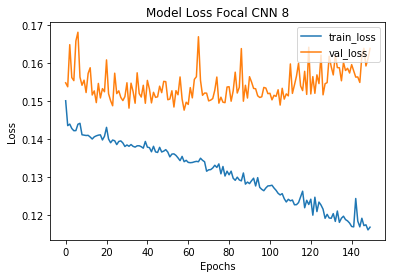

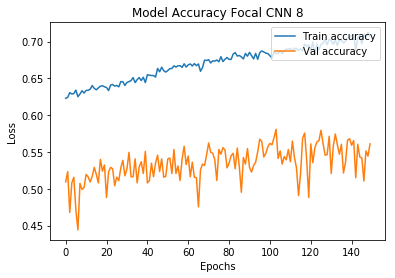

                F1 macro  F1 micro    F1 raw  F1 weighted  Precision raw  \
False Positive  0.560537  0.561022  0.575139     0.565716       0.834829   
Confirmed       0.560537  0.561022  0.545935     0.565716       0.409722   

                Recall raw  
False Positive    0.438679  
Confirmed         0.817822  


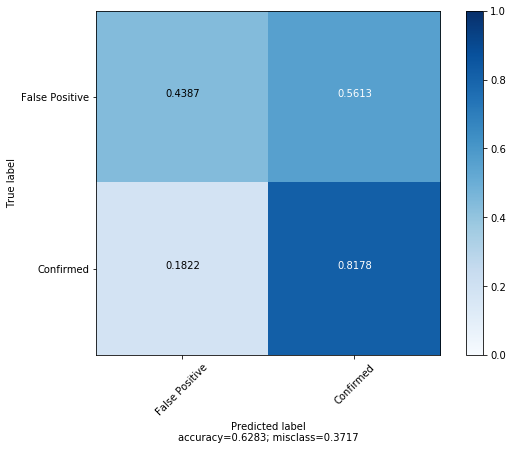

{'F1 macro': 0.5605371872957559, 'Recall raw': array([0.43867925, 0.81782178]), 'Confusion Matrix': array([[465, 595],
       [ 92, 413]]), 'Precision raw': array([0.83482944, 0.40972222]), 'F1 weighted': 0.5657155179001898, 'F1 micro': 0.5610223642172524, 'F1 raw': array([0.57513915, 0.54593523])}


In [21]:
model8 = Sequential()
model8.add(Conv2D(32, (3, 3), input_shape=(15,15,1), strides=(1, 1),activation="relu", padding="same"))
model8.add(Dropout(0.15))
model8.add(Conv2D(64, (3, 3), strides=(1, 1), activation="relu", padding="same"))
model8.add(Dropout(0.15))
model8.add(Conv2D(128, (3, 3), strides=(1, 1), activation="relu", padding="same"))
model8.add(GlobalAveragePooling2D())
model8.add(Dense(256,activation='relu'))
model8.add(Dropout(0.3))
model8.add(Dense(128, activation='relu'))
model8.add(Dropout(0.15))
model8.add(Dense(2, activation='softmax'))
model8.summary()

model8.compile(loss=focal_loss(2,weights=class_weights),optimizer='adam',metrics=['acc'])

hist8=model8.fit(x_train, y_train_cat, batch_size=128, epochs=150, verbose=0, class_weight=class_weights, validation_data=(x_val,y_val_cat))
plt.plot(hist8.history['loss'],label="train_loss")
plt.plot(hist8.history['val_loss'],label="val_loss")
plt.title("Model Loss Focal CNN 8") 
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(loc="upper right")
plt.show()

plt.plot(hist8.history['acc'],label="Train accuracy" )
plt.plot(hist8.history['val_acc'],label="Val accuracy" )
plt.title("Model Accuracy Focal CNN 8") 
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(loc="upper right")
plt.show()

predichos=model8.predict_classes(x_val)
print (calculate_metrics(y_val,predichos,'[VAL] Confusion Matrix 150 epochs CNN 8 Focal'))

In [28]:
x_train.shape

(4692, 15, 15, 1)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_20 (Conv1D)           (None, 15, 32)            1472      
_________________________________________________________________
conv1d_21 (Conv1D)           (None, 15, 32)            3104      
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 7, 32)             0         
_________________________________________________________________
dropout_28 (Dropout)         (None, 7, 32)             0         
_________________________________________________________________
conv1d_22 (Conv1D)           (None, 7, 64)             6208      
_________________________________________________________________
conv1d_23 (Conv1D)           (None, 7, 64)             12352     
_________________________________________________________________
max_pooling1d_7 (MaxPooling1 (None, 3, 64)             0         
__________

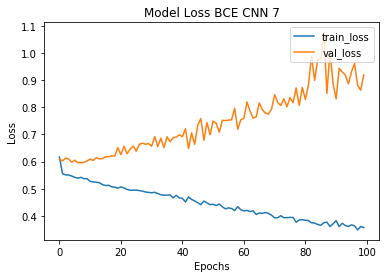

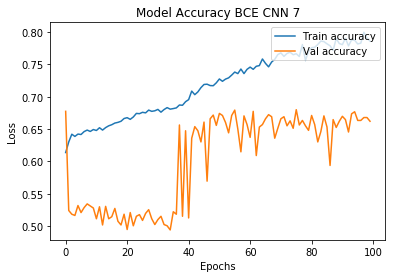

                F1 macro  F1 micro    F1 raw  F1 weighted  Precision raw  \
False Positive  0.600958  0.661981  0.757005     0.656297       0.737690   
Confirmed       0.600958  0.661981  0.444911     0.656297       0.473214   

                Recall raw  
False Positive    0.777358  
Confirmed         0.419802  


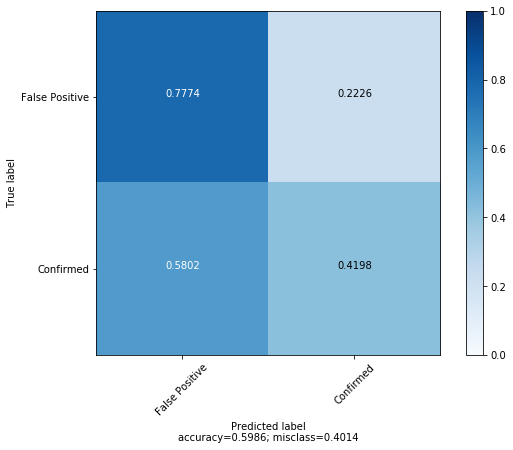

{'F1 macro': 0.6009579303999024, 'Recall raw': array([0.77735849, 0.41980198]), 'Confusion Matrix': array([[824, 236],
       [293, 212]]), 'Precision raw': array([0.73769024, 0.47321429]), 'F1 weighted': 0.6562973252535271, 'F1 micro': 0.6619808306709265, 'F1 raw': array([0.75700505, 0.44491081])}


In [33]:
model9 = Sequential()
model9.add(Conv1D(32, 3, input_shape=(15,15), strides=1,activation="relu", padding="same"))
model9.add(Conv1D(32, 3, strides=1, activation="relu", padding="same"))
model9.add(MaxPooling1D(2))
model9.add(Dropout(0.25))

#model7.add(Dropout(0.15))
model9.add(Conv1D(64, 3, strides=1, activation="relu", padding="same"))
model9.add(Conv1D(64, 3, strides=1, activation="relu", padding="same"))
model9.add(MaxPooling1D(2))
model9.add(Dropout(0.25))

model9.add(Conv1D(128, 3, strides=1, activation="relu", padding="same"))
model9.add(Conv1D(128, 3, strides=1, activation="relu", padding="same"))
#model7.add(MaxPooling2D((2,2)))
model9.add(Dropout(0.25))

model9.add(GlobalAveragePooling1D())
model9.add(Dense(128,activation='relu'))
model9.add(Dropout(0.5))
model9.add(Dense(1, activation='sigmoid'))
model9.summary()

model9.compile(loss='binary_crossentropy',optimizer='adam',metrics=['acc'])

hist9=model9.fit(np.squeeze(x_train), y_train, batch_size=128, epochs=100, verbose=0, class_weight=class_weights, validation_data=(np.squeeze(x_val),y_val))
plt.plot(hist9.history['loss'],label="train_loss")
plt.plot(hist9.history['val_loss'],label="val_loss")
plt.title("Model Loss BCE CNN 7") 
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(loc="upper right")
plt.show()

plt.plot(hist9.history['acc'],label="Train accuracy" )
plt.plot(hist9.history['val_acc'],label="Val accuracy" )
plt.title("Model Accuracy BCE CNN 7") 
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(loc="upper right")
plt.show()

predichos=model9.predict_classes(np.squeeze(x_val))
print (calculate_metrics(y_val,predichos,'[VAL] Confusion Matrix 100 epochs CNN 9 BCE'))